In [356]:
import argparse

import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl.nn as dglnn
from dgl import AddSelfLoop
from dgl.data import CoraGraphDataset
import torch
import torch.nn as nn
import torch.nn.functional as F

In [389]:
import os
os.environ['DGLBACKEND'] = 'pytorch'
import torch as th
import torch.nn as nn
import torch.nn.functional as F

import dgl
import dgl.function as fn
from dgl import DGLGraph


In [392]:
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature, mask=None):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            
            if mask is not None:
                g.ndata["h"] = feature[mask]
            else:
                g.ndata["h"] = feature
            
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata["h"]
            return self.linear(h)

class Net(nn.Module):
    def __init__(self, feats_shape):
        super(Net, self).__init__()
        n = 512
        self.layer1 = GCNLayer(n, 16)
        self.layer2 = GCNLayer(16, 7)
        self.features = nn.Parameter(torch.randn((feats_shape[0], n)))
        self.features.requires_grad = True
        

    def forward(self, g, mask):
        features2 = self.features
        x = F.relu(self.layer1(g, features2, mask))
        x = self.layer2(g, x)
        return x


def evaluate(model, g, features, labels, mask, fmask):
    model.eval()
    with th.no_grad():
        logits = model(g, fmask)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = th.max(logits, dim=1)
        correct = th.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)
    
gcn_msg = fn.copy_u(u="h", out="m")
gcn_reduce = fn.sum(msg="m", out="h")


In [394]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

In [395]:
# topk = [8,3,4,5]
# g = dgl.remove_nodes(g, topk)

# new_feats = g.ndata["feat"]


# for i in topk:
#     mask[id_map[int(i)]] = False
    
    
# idx = -1
# new_id_map = {}
# for i in range(len(mask)):
#     if mask[i]:
#         idx += 1

#         new_id_map[idx] = i
# id_map = new_id_map

# print((new_feats[100] == old_feats[id_map[100]]).sum())


In [406]:


import time

import numpy as np

# net = Net()
# # Add edges between each node and itself to preserve old node representations
# g.add_edges(g.nodes(), g.nodes())
id_map = {}


epochs = 50

seeds = [10,20,30,40]
dur = np.zeros((len(seeds), epochs))
test_acc = np.zeros((len(seeds), epochs))
train_loss = np.zeros((len(seeds), epochs))
nets = []
f_masks = []

for i_s, seed in enumerate(seeds):
    

    set_seed(seed)
    dataset = CoraGraphDataset()
    g = dataset[0]
    features = g.ndata["feat"]
    labels = g.ndata["label"]
    train_mask = g.ndata["train_mask"]
    test_mask = g.ndata["test_mask"]
    val_mask = g.ndata["val_mask"]
    
    net = Net(g.ndata["feat"].shape)
    optimizer = th.optim.Adam(net.parameters(), lr=1e-2)

    # Add edges between each node and itself to preserve old node representations
    g.add_edges(g.nodes(), g.nodes())
    E = torch.zeros(train_mask.shape[0])
    k = 50
    mask = torch.ones(g.ndata["feat"].shape[0]).bool()
    id_map = {}
    for i in range(g.ndata["feat"].shape[0]):
        id_map[i] = i

    for epoch in range(epochs):
        if epoch >= 3:
            t0 = time.time()

        net.train()
        logits = net(g, mask)
        logp = F.log_softmax(logits, 1)

        correct = torch.argmax(logp, dim=1) == labels
        correct[~(train_mask+val_mask)] = False
        E += correct

        loss = F.nll_loss(logp[train_mask], labels[train_mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 3 == 0 and epoch != 0 and epoch > 10 and epoch < 45:
            E = E/4
            topk = np.argpartition(E, -k)[-k:]
            g = dgl.remove_nodes(g, topk)
            
            for i in topk:
                mask[id_map[int(i)]] = False

            idx = -1
            new_id_map = {}
            for i in range(len(mask)):
                if mask[i]:
                    idx += 1
                    
                    new_id_map[idx] = i
            
            id_map = new_id_map
                
            labels = g.ndata["label"]
            train_mask = g.ndata["train_mask"]
            val_mask = g.ndata["val_mask"]
            E = torch.zeros(train_mask.shape[0])
            k = int(0.9*k)
            print(sum(train_mask), sum(val_mask), sum(mask))

        acc = evaluate(net, g, features, labels, val_mask, mask)
        print(
            "Epoch {:05d} | Loss {:.4f} | Test Acc {:.4f}".format(
                epoch, loss.item(), acc
            )
        )
        test_acc[i_s][epoch] = acc
        train_loss[i_s][epoch] = loss.item()
        nets.append(net)
        f_masks.append(mask)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch 00000 | Loss 6.2379 | Test Acc 0.2920
Epoch 00001 | Loss 1.7343 | Test Acc 0.3820
Epoch 00002 | Loss 0.8858 | Test Acc 0.4380
Epoch 00003 | Loss 0.5885 | Test Acc 0.4740
Epoch 00004 | Loss 0.3906 | Test Acc 0.4940
Epoch 00005 | Loss 0.2419 | Test Acc 0.5040
Epoch 00006 | Loss 0.1336 | Test Acc 0.5100
Epoch 00007 | Loss 0.0599 | Test Acc 0.5120
Epoch 00008 | Loss 0.0436 | Test Acc 0.4960
Epoch 00009 | Loss 0.0376 | Test Acc 0.5080
Epoch 00010 | Loss 0.0238 | Test Acc 0.5260
Epoch 00011 | Loss 0.0133 | Test Acc 0.5240
tensor(120) tensor(470) tensor(2658)
Epoch 00012 | Loss 0.0091 | Test Acc 0.4851
Epoch 00013 | Loss 0.0088 | Test Acc 0.4957
Epoch 00014 | Loss 0.0063 | Test Acc 0.4936
tensor(119) tensor(426) tensor(2613)
Epoch 00015 | Loss 0.0045 | Test Acc 0.4460
Epoch 00016 | Loss 0.0168 | Test Acc 0.4

Epoch 00047 | Loss 0.0001 | Test Acc 0.0727
Epoch 00048 | Loss 0.0001 | Test Acc 0.0727
Epoch 00049 | Loss 0.0001 | Test Acc 0.0727
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch 00000 | Loss 3.1221 | Test Acc 0.3820
Epoch 00001 | Loss 0.9167 | Test Acc 0.4560
Epoch 00002 | Loss 0.4406 | Test Acc 0.4900
Epoch 00003 | Loss 0.2438 | Test Acc 0.5160
Epoch 00004 | Loss 0.1487 | Test Acc 0.5240
Epoch 00005 | Loss 0.0991 | Test Acc 0.5320
Epoch 00006 | Loss 0.0701 | Test Acc 0.5320
Epoch 00007 | Loss 0.0525 | Test Acc 0.5280
Epoch 00008 | Loss 0.0398 | Test Acc 0.5240
Epoch 00009 | Loss 0.0302 | Test Acc 0.5220
Epoch 00010 | Loss 0.0228 | Test Acc 0.5200
Epoch 00011 | Loss 0.0171 | Test Acc 0.5220
tensor(126) tensor(464) tensor(2658)
Epoch 00012 | Loss 0.0126 | Test Acc 0.4828
Epoch 00013 | Loss 0.0181 | Test Acc 0.4871
Epoch 00014 | Loss 0.0143 | Test 

In [407]:
accs = []
for i, net in enumerate(nets):
    accs.append(evaluate(net, g, features, labels, g.ndata['test_mask'], f_masks[i]))
print(np.mean(accs))

0.4960000000000001


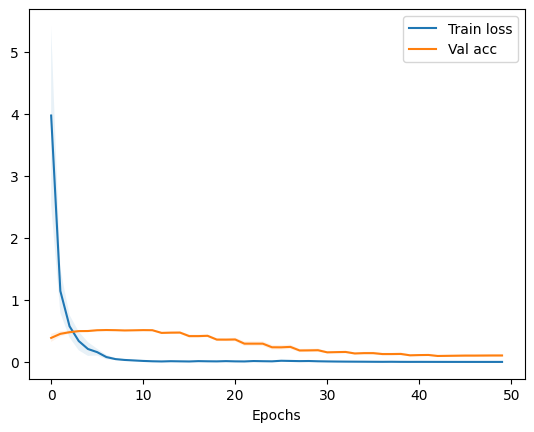

In [408]:

import matplotlib.pyplot as plt 

fig = plt.figure()
# temp_test_acc = train_loss.transpose(1, 0, 2)
# print(temp_test_acc.shape)

acc_means = np.mean(test_acc, axis=0)
acc_stds = np.std(test_acc, axis=0)

loss_means = np.mean(train_loss, axis=0)
loss_stds = np.std(train_loss, axis=0)

plt.plot(loss_means[:], label="Train loss")
plt.fill_between(range(len(loss_means[:])), loss_means[:] - loss_stds[:], loss_means[:] + loss_stds[:], alpha=0.1)


# for i in range(3):
    # plt.plot(test_acc[i,:10], label=f"Subset size: {subset_sizes[i]}")
plt.plot(acc_means[:], label="Val acc")
plt.fill_between(range(len(acc_means[:])), acc_means[:] - acc_stds[:], acc_means[:] + acc_stds[:], alpha=0.1)



plt.legend()
plt.xlabel("Epochs")
# plt.ylabel("Test Accuracy")
plt.show()



In [382]:
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, feature):
        # Creating a local scope so that all the stored ndata and edata
        # (such as the `'h'` ndata below) are automatically popped out
        # when the scope exits.
        with g.local_scope():
            g.ndata["h"] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata["h"]
            return self.linear(h)

        
class Net(nn.Module):
    def __init__(self, feats_shape):
        super(Net, self).__init__()g
        n = 512
        self.layer1 = GCNLayer(n, 16)
        self.layer2 = GCNLayer(16, 7)
        self.features = nn.Parameter(torch.randn((feats_shape[0], n)))
        self.features.requires_grad = True

    def forward(self, g):
        x = F.relu(self.layer1(g, self.features))
        x = self.layer2(g, x)
        return x
    
    

def evaluate(model, g, features, labels, mask):
    model.eval()
    with th.no_grad():
        logits = model(g)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = th.max(logits, dim=1)
        correct = th.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)
    
gcn_msg = fn.copy_u(u="h", out="m")
gcn_reduce = fn.sum(msg="m", out="h")


In [384]:
dataset = CoraGraphDataset()
g = dataset[0]
features = g.ndata["feat"]
labels = g.ndata["label"]
train_mask = g.ndata["train_mask"]
test_mask = g.ndata["test_mask"]
val_mask = g.ndata["val_mask"]

epochs = 50

seeds = [10,20,30,40]
dur = np.zeros((len(seeds), epochs))
test_acc = np.zeros((len(seeds), epochs))
train_loss = np.zeros((len(seeds), epochs))
nets = []
# E = torch.zeros(train_mask.shape[0])
# k = 60


for i_s, seed in enumerate(seeds):
    set_seed(seed)
    dataset = CoraGraphDataset()
    g = dataset[0]
#     features = g.ndata["feat"]
    labels = g.ndata["label"]
    train_mask = g.ndata["train_mask"]
    test_mask = g.ndata["test_mask"]
    val_mask = g.ndata["val_mask"]
    
    net = Net(g.ndata["feat"].shape)
    optimizer = th.optim.Adam(net.parameters(), lr=1e-2)

    # Add edges between each node and itself to preserve old node representations
    g.add_edges(g.nodes(), g.nodes())
    E = torch.zeros(train_mask.shape[0])

    for epoch in range(epochs):
        if epoch >= 3:
            t0 = time.time()

        net.train()
        logits = net(g)
        logp = F.log_softmax(logits, 1)

        correct = torch.argmax(logp, dim=1) == labels
        correct[~(train_mask+val_mask)] = False
        E += correct

        loss = F.nll_loss(logp[train_mask], labels[train_mask])
        
        optimizer.zero_grad()
        loss.backward()
#         print(net.features.grad)
        optimizer.step()

#         if epoch >= 3:
#             dur.append(time.time() - t0)

        acc = evaluate(net, g, features, labels, val_mask)
        print(
            "Epoch {:05d} | Loss {:.4f} | Test Acc {:.4f}".format(
                epoch, loss.item(), acc
            )
        )
        test_acc[i_s][epoch] = acc
        train_loss[i_s][epoch] = loss.item()
        nets.append(net)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch 00000 | Loss 6.2379 | Test Acc 0.2920
Epoch 00001 | Loss 1.7343 | Test Acc 0.3820
Epoch 00002 | Loss 0.8858 | Test Acc 0.4380
Epoch 00003 | Loss 0.5885 | Test Acc 0.4740
Epoch 00004 | Loss 0.3906 | Test Acc 0.4940
Epoch 00005 | Loss 0.2419 | Test Acc 0.5040
Epoch 00006 | Loss 0.1336 | Test Acc 0.5100
Epoch 00007 | Loss 0.0599 | Test Acc 0.5120
Epoch 00008 | Loss 0.0436 | Test Acc 0.4960
Epoch 00009 | Loss 0.0376 | Test Acc 0.5080
Epoch 00010 | Loss 0.0238 | Test Acc 0.5260
Epoch 00011 | Loss 0.0133 | Test Acc 0.5240
Epoch 00012 | Loss 0.0091 | Test Acc 0.5300
Epoch 00013 | Loss 0.0063 | Test Acc 0.5360
Epoch 00014 | Loss 0

Epoch 00018 | Loss 0.0018 | Test Acc 0.5380
Epoch 00019 | Loss 0.0013 | Test Acc 0.5380
Epoch 00020 | Loss 0.0010 | Test Acc 0.5400
Epoch 00021 | Loss 0.0007 | Test Acc 0.5380
Epoch 00022 | Loss 0.0006 | Test Acc 0.5400
Epoch 00023 | Loss 0.0005 | Test Acc 0.5400
Epoch 00024 | Loss 0.0004 | Test Acc 0.5440
Epoch 00025 | Loss 0.0003 | Test Acc 0.5420
Epoch 00026 | Loss 0.0003 | Test Acc 0.5400
Epoch 00027 | Loss 0.0002 | Test Acc 0.5380
Epoch 00028 | Loss 0.0002 | Test Acc 0.5380
Epoch 00029 | Loss 0.0002 | Test Acc 0.5380
Epoch 00030 | Loss 0.0001 | Test Acc 0.5380
Epoch 00031 | Loss 0.0001 | Test Acc 0.5400
Epoch 00032 | Loss 0.0001 | Test Acc 0.5400
Epoch 00033 | Loss 0.0001 | Test Acc 0.5400
Epoch 00034 | Loss 0.0001 | Test Acc 0.5400
Epoch 00035 | Loss 0.0001 | Test Acc 0.5400
Epoch 00036 | Loss 0.0001 | Test Acc 0.5400
Epoch 00037 | Loss 0.0001 | Test Acc 0.5400
Epoch 00038 | Loss 0.0001 | Test Acc 0.5400
Epoch 00039 | Loss 0.0001 | Test Acc 0.5400
Epoch 00040 | Loss 0.0001 | Test

In [385]:
accs = []
for net in nets:
    accs.append(evaluate(net, g, features, labels, g.ndata['test_mask']))
print(np.mean(accs))

0.529


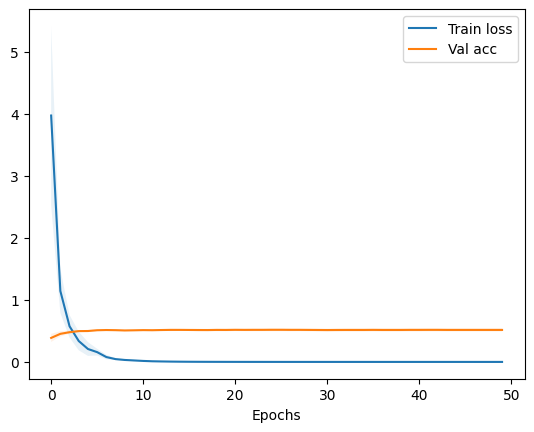

In [386]:

import matplotlib.pyplot as plt 

fig = plt.figure()
# temp_test_acc = train_loss.transpose(1, 0, 2)
# print(temp_test_acc.shape)

acc_means = np.mean(test_acc, axis=0)
acc_stds = np.std(test_acc, axis=0)

loss_means = np.mean(train_loss, axis=0)
loss_stds = np.std(train_loss, axis=0)

plt.plot(loss_means[:], label="Train loss")
plt.fill_between(range(len(loss_means[:])), loss_means[:] - loss_stds[:], loss_means[:] + loss_stds[:], alpha=0.1)


# for i in range(3):
    # plt.plot(test_acc[i,:10], label=f"Subset size: {subset_sizes[i]}")
plt.plot(acc_means[:], label="Val acc")
plt.fill_between(range(len(acc_means[:])), acc_means[:] - acc_stds[:], acc_means[:] + acc_stds[:], alpha=0.1)



plt.legend()
plt.xlabel("Epochs")
# plt.ylabel("Test Accuracy")
plt.show()



In [410]:


import time

import numpy as np


nets = []
# Add edges between each node and itself to preserve old node representations
epochs = 50
f_masks = []
seeds = [10,20,30,40]
dur = np.zeros((len(seeds), epochs))
test_acc = np.zeros((len(seeds), epochs))
train_loss = np.zeros((len(seeds), epochs))

for i_s, seed in enumerate(seeds):
    set_seed(seed)
    dataset = CoraGraphDataset()
    g = dataset[0]
    features = g.ndata["feat"]
    labels = g.ndata["label"]
    train_mask = g.ndata["train_mask"]
    test_mask = g.ndata["test_mask"]
    val_mask = g.ndata["val_mask"]
    
    net = Net(g.ndata["feat"].shape)
    optimizer = th.optim.Adam(net.parameters(), lr=1e-2)

    # Add edges between each node and itself to preserve old node representations
    g.add_edges(g.nodes(), g.nodes())
    E = torch.zeros(train_mask.shape[0])
    k = 50
    mask = torch.ones(g.ndata["feat"].shape[0]).bool()
    id_map = {}

    for i in range(g.ndata["feat"].shape[0]):
        id_map[i] = i
    
    
    for epoch in range(epochs):
        if epoch >= 3:
            t0 = time.time()

        net.train()
        logits = net(g, mask)
        logp = F.log_softmax(logits, 1)

        correct = torch.argmax(logp, dim=1) == labels
        correct[~(train_mask+val_mask)] = False

        loss = F.nll_loss(logp[train_mask], labels[train_mask])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if epoch % 3 == 0 and epoch != 0 and epoch < 45 and epoch > 10:
            true_idx = np.argwhere(train_mask + val_mask)[0]
            remove_idx = np.random.choice(true_idx, size=k, replace=False)
            
            for i in remove_idx:
                mask[id_map[int(i)]] = False
            
            g = dgl.remove_nodes(g, remove_idx)
            
            idx = -1
            new_id_map = {}
            for i in range(len(mask)):
                if mask[i]:
                    idx += 1
                    
                    new_id_map[idx] = i
            
            id_map = new_id_map
            
            
            features = g.ndata["feat"]
            labels = g.ndata["label"]
            train_mask = g.ndata["train_mask"]
            val_mask = g.ndata["val_mask"]
            E = torch.zeros(train_mask.shape[0])
            k = int(0.9*k)
            print(sum(train_mask), sum(val_mask), sum(mask))

        acc = evaluate(net, g, features, labels, val_mask, mask)
        print(
            "Epoch {:05d} | Loss {:.4f} | Test Acc {:.4f}".format(
                epoch, loss.item(), acc
            )
        )
        test_acc[i_s][epoch] = acc
        train_loss[i_s][epoch] = loss.item()
        nets.append(net)
        f_masks.append(mask)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch 00000 | Loss 6.2379 | Test Acc 0.2920
Epoch 00001 | Loss 1.7343 | Test Acc 0.3820
Epoch 00002 | Loss 0.8858 | Test Acc 0.4380
Epoch 00003 | Loss 0.5885 | Test Acc 0.4740
Epoch 00004 | Loss 0.3906 | Test Acc 0.4940
Epoch 00005 | Loss 0.2419 | Test Acc 0.5040
Epoch 00006 | Loss 0.1336 | Test Acc 0.5100
Epoch 00007 | Loss 0.0599 | Test Acc 0.5120
Epoch 00008 | Loss 0.0436 | Test Acc 0.4960
Epoch 00009 | Loss 0.0376 | Test Acc 0.5080
Epoch 00010 | Loss 0.0238 | Test Acc 0.5260
Epoch 00011 | Loss 0.0133 | Test Acc 0.5240
tensor(129) tensor(461) tensor(2658)
Epoch 00012 | Loss 0.0091 | Test Acc 0.5119
Epoch 00013 | Loss 0.0080 | Test Acc 0.5163
Epoch 00014 | Loss 0.0058 | Test Acc 0.5163
tensor(120) tensor(425) tensor(2613)
Epoch 00015 | Loss 0.0044 | Test Acc 0.5318
Epoch 00016 | Loss 0.0037 | Test Acc 0.5

Epoch 00049 | Loss 0.0005 | Test Acc 0.4606
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch 00000 | Loss 3.1221 | Test Acc 0.3820
Epoch 00001 | Loss 0.9167 | Test Acc 0.4560
Epoch 00002 | Loss 0.4406 | Test Acc 0.4900
Epoch 00003 | Loss 0.2438 | Test Acc 0.5160
Epoch 00004 | Loss 0.1487 | Test Acc 0.5240
Epoch 00005 | Loss 0.0991 | Test Acc 0.5320
Epoch 00006 | Loss 0.0701 | Test Acc 0.5320
Epoch 00007 | Loss 0.0525 | Test Acc 0.5280
Epoch 00008 | Loss 0.0398 | Test Acc 0.5240
Epoch 00009 | Loss 0.0302 | Test Acc 0.5220
Epoch 00010 | Loss 0.0228 | Test Acc 0.5200
Epoch 00011 | Loss 0.0171 | Test Acc 0.5220
tensor(129) tensor(461) tensor(2658)
Epoch 00012 | Loss 0.0126 | Test Acc 0.5228
Epoch 00013 | Loss 0.0091 | Test Acc 0.5293
Epoch 00014 | Loss 0.0066 | Test Acc 0.5293
tensor(120) tensor(425) tensor(2613)
Epoch 00015 | Loss 0.0047 | Test Acc 0.5

In [411]:
accs = []
for i, net in enumerate(nets):
    accs.append(evaluate(net, g, features, labels, g.ndata['test_mask'], f_masks[i]))
print(np.mean(accs))

0.4917499999999999


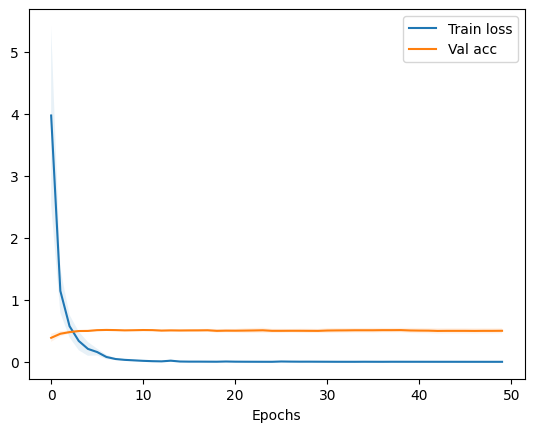

In [412]:

import matplotlib.pyplot as plt 

fig = plt.figure()
# temp_test_acc = train_loss.transpose(1, 0, 2)
# print(temp_test_acc.shape)

acc_means = np.mean(test_acc, axis=0)
acc_stds = np.std(test_acc, axis=0)

loss_means = np.mean(train_loss, axis=0)
loss_stds = np.std(train_loss, axis=0)

plt.plot(loss_means[:], label="Train loss")
plt.fill_between(range(len(loss_means[:])), loss_means[:] - loss_stds[:], loss_means[:] + loss_stds[:], alpha=0.1)


# for i in range(3):
    # plt.plot(test_acc[i,:10], label=f"Subset size: {subset_sizes[i]}")
plt.plot(acc_means[:], label="Val acc")
plt.fill_between(range(len(acc_means[:])), acc_means[:] - acc_stds[:], acc_means[:] + acc_stds[:], alpha=0.1)



plt.legend()
plt.xlabel("Epochs")
# plt.ylabel("Test Accuracy")
plt.show()

